<a href="https://colab.research.google.com/github/daquarti/AI/blob/main/Donut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -q "transformers>=4.22.0" # comment in when version is released
!pip install -q datasets sentencepiece tensorboard
# install git-fls for pushing model and logs to the hugging face hub
!sudo apt-get install git-lfs --yes


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.


In [ ]:
from huggingface_hub import notebook_login

notebook_login()


Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
%%bash
# clone repository
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
# copy data
cp -r ICDAR-2019-SROIE/data ./
# clean up
rm -r ICDAR-2019-SROIE
rm -r data/box


Cloning into 'ICDAR-2019-SROIE'...
Checking out files: 100% (1980/1980), done.


In [ ]:
import os
import json
from pathlib import Path
import shutil


In [ ]:
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")

In [ ]:
import random
lista_sample = random.choices(list (image_path.glob("*.jpg")), k=100)

In [ ]:
for x in lista_sample:
  shutil.copy(x, '/content/data/img_g')
  m = metadata_path.joinpath(f"{x.stem}.json")
  shutil.copy(m, '/content/data/key_g')


Lo paso a string pero de forma que tenga "", ya que así es un json

In [ ]:
import os
import json
from pathlib import Path
import shutil

# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []

# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      # delete json file

# write jsonline file

with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')

# remove old meta data
shutil.rmtree(metadata_path)


In [ ]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset


image_path = base_path.joinpath("img")

# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")

print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")


Resolving data files:   0%|          | 0/627 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-d85086e84be23476/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.
Dataset has 626 images
Dataset features are: dict_keys(['image', 'text'])


In [ ]:
dataset

Dataset({
    features: ['image', 'text'],
    num_rows: 626
})

In [ ]:
dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=463x1013 at 0x7F46F29EDD50>,
 'text': '{"company": "BOOK TA .K (TAMAN DAYA) SDN BHD", "date": "25/12/2018", "address": "NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.", "total": "9.00"}'}

In [ ]:
# El load dataset me carga por default la metadatada y me genera las labels

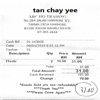

In [ ]:
dataset[5]['image'].resize ((100, 100))

Random sample is 370
OCR text is {"company": "GARDENIA BAKERIES (KL) SDN BHD", "date": "12/10/2017", "address": "LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.", "total": "59.54"}


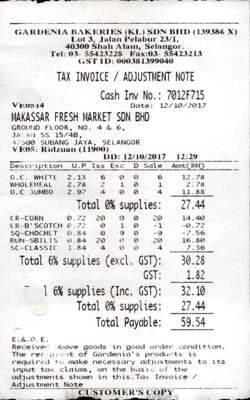

In [ ]:
import random

random_sample = random.randint(0, len(dataset))

print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))
#     OCR text is {"company": "LIM SENG THO HARDWARE TRADING", "date": "29/12/2017", "address": "NO 7, SIMPANG OFF BATU VILLAGE, JALAN IPOH BATU 5, 51200 KUALA LUMPUR MALAYSIA", "total": "6.00"}


In [ ]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer

def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj


def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}

#proc_dataset = dataset.map(preprocess_documents_for_donut)

#print(f"Sample: {proc_dataset[45]['text']}")
#print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")
#    Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
#    New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


In [ ]:
dataset[0]['text']

'{"company": "BOOK TA .K (TAMAN DAYA) SDN BHD", "date": "25/12/2018", "address": "NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.", "total": "9.00"}'

In [ ]:
proc_dataset = dataset.map(preprocess_documents_for_donut, writer_batch_size=32, batch_size=32)

  0%|          | 0/626 [00:00<?, ?ex/s]

In [ ]:
print(f"Sample: {proc_dataset[45]['text']}")

Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>


In [ ]:
from transformers import DonutProcessor

# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")

# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})

# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}

    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)

    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}

# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"], writer_batch_size=32, batch_size=32)


  0%|          | 0/626 [00:00<?, ?ex/s]

In [ ]:
from datasets import load_from_disk

In [ ]:
# from datasets import load_from_disk
# from transformers import DonutProcessor

## COMMENT IN in case you want to save the processed dataset to disk in case of error later
processed_dataset.save_to_disk("/processed_dataset")
processor.save_pretrained("/processor")

## COMMENT IN in case you want to load the processed dataset from disk in case of error later
processed_dataset = load_from_disk('/processed_dataset')
processor = DonutProcessor.from_pretrained("/processor")



In [ ]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)


DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 563
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 63
    })
})


In [ ]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig

# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")

# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))

# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

# is done by Trainer
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)


Downloading:   0%|          | 0.00/4.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/809M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


New embedding size: Embedding(57533, 1024)


In [ ]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

# hyperparameters used for multiple args
hf_repository_id = "donut-base-sroie"

# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)

# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)


ValueError: ignored

In [ ]:
processed_dataset["train"]

Dataset({
    features: ['pixel_values', 'labels', 'target_sequence'],
    num_rows: 87
})

In [ ]:
# Start training
trainer.train()


The following columns in the training set don't have a corresponding argument in `VisionEncoderDecoderModel.forward` and have been ignored: target_sequence. If target_sequence are not expected by `VisionEncoderDecoderModel.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 87
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 132


Step,Training Loss
100,3.672500


Saving model checkpoint to donut-base-sroie/checkpoint-44
Configuration saved in donut-base-sroie/checkpoint-44/config.json
Model weights saved in donut-base-sroie/checkpoint-44/pytorch_model.bin
Saving model checkpoint to donut-base-sroie/checkpoint-88
Configuration saved in donut-base-sroie/checkpoint-88/config.json
Model weights saved in donut-base-sroie/checkpoint-88/pytorch_model.bin
Saving model checkpoint to donut-base-sroie/checkpoint-132
Configuration saved in donut-base-sroie/checkpoint-132/config.json
Model weights saved in donut-base-sroie/checkpoint-132/pytorch_model.bin
Deleting older checkpoint [donut-base-sroie/checkpoint-44] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=132, training_loss=3.1555172891327827, metrics={'train_runtime': 434.505, 'train_samples_per_second': 0.601, 'train_steps_per_second': 0.304, 'total_flos': 4.590697167654912e+17, 'train_loss': 3.1555172891327827, 'epoch': 3.0})

In [ ]:
# Save processor and create model card
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()


Feature extractor saved in donut-base-sroie/preprocessor_config.json
tokenizer config file saved in donut-base-sroie/tokenizer_config.json
Special tokens file saved in donut-base-sroie/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'dataset': {'name': 'imagefolder', 'type': 'imagefolder', 'config': 'default', 'split': 'train', 'args': 'default'}}
Saving model checkpoint to donut-base-sroie
Configuration saved in donut-base-sroie/config.json
Model weights saved in donut-base-sroie/pytorch_model.bin
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/772M [00:00<?, ?B/s]

Upload file sentencepiece.bpe.model:   0%|          | 3.34k/1.24M [00:00<?, ?B/s]

Upload file runs/Oct06_15-22-37_cbf2fb1ceb9d/events.out.tfevents.1665069790.cbf2fb1ceb9d.7223.0:  39%|###9    …

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/daquarti/donut-base-sroie
   89fb0e9..fc0a88b  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/daquarti/donut-base-sroie
   89fb0e9..fc0a88b  main -> main

Dropping the following result as it does not have all the necessary fields:
{'dataset': {'name': 'imagefolder', 'type': 'imagefolder', 'config': 'default', 'split': 'train', 'args': 'default'}}


'https://huggingface.co/daquarti/donut-base-sroie/commit/fc0a88bae7cfe57988b1203ebf9a1620a89e405a'

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/257 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/485 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/809M [00:00<?, ?B/s]

Reference:
 {'total': '39.80', 'date': '20/11/2017', 'company': 'LIGHTROOM GALLERY SDN BHD', 'address': 'NO: 28, JALAN ASTANA 1C, BANDAR BUKIT RAJA, 41050 KLANG SELANGOR D.E, MALAYSIA'}
Prediction:
 {'total': '31.80', 'date': '20/11/2017', 'company': 'LIGHTROM GALLERY SDN BHD'}


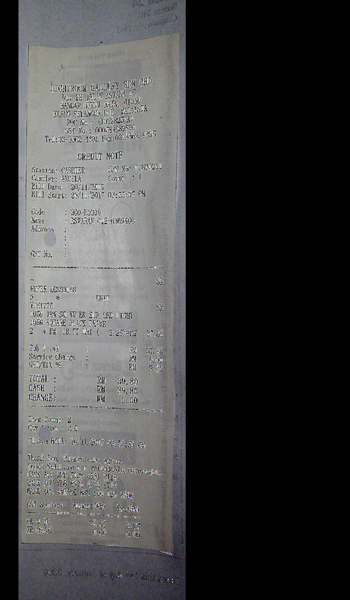

In [ ]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np

# hidde logs
transformers.logging.disable_default_handler()


# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("daquarti/donut-base-sroie")
model = VisionEncoderDecoderModel.from_pretrained("daquarti/donut-base-sroie")

# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 50)]

def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)

    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target

prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))


In [ ]:
test_sample = processed_dataset["test"][random.randint(1, 3)]

Reference:
 {'total': 'RM 34.80', 'date': '19-04-18', 'company': 'MR. D.I.Y. (M) SDN BHD', 'address': 'LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR'}
Prediction:
 {'total': 'RM 1.97', 'date': '08/04/2018', 'company': 'MR. D.I.Y. (M) SDN BHD', 'address': 'LOT 1881-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKNG, 43300 SERI KEMBANGKA, SELANGOR'}


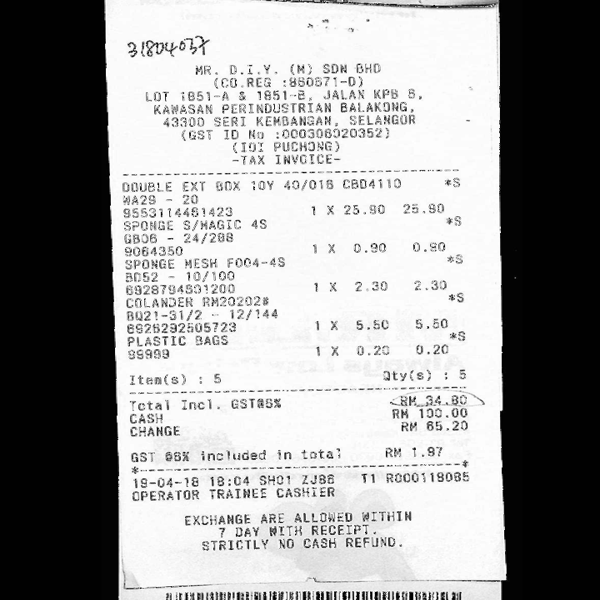

In [ ]:
prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((600,600))


In [ ]:
from tqdm import tqdm

# define counter for samples
true_counter = 0
total_counter = 0

# iterate over dataset
for sample in tqdm(processed_dataset["test"]):
  prediction, target = run_prediction(test_sample)
  for s in zip(prediction.values(), target.values()):
    if s[0] == s[1]:
      true_counter += 1
    total_counter += 1

print(f"Accuracy: {(true_counter/total_counter)*100}%")
# Accuracy: 75.0%


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]

Accuracy: 25.0%


In [ ]:
https://www.philschmid.de/fine-tuning-donut